<a href="https://colab.research.google.com/github/pinakm9/sphere-fp/blob/master/data/8D/sphere8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required modules**

In [1]:
# run this cell to download data and necessary modules
import os, shutil
repo = 'sphere-fp'
if os.path.isdir(repo):
  shutil.rmtree(repo)
!git clone https://github.com/pinakm9/sphere-fp.git
# add modules folder to Python's search path
import sys
sys.path.insert(0, repo + '/modules')
# import the necessary modules
import numpy as np
import tensorflow as tf
import lss_solver as lss
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Cloning into 'sphere-fp'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 139 (delta 2), reused 8 (delta 1), pack-reused 121
Receiving objects: 100% (139/139), 48.01 MiB | 30.14 MiB/s, done.
Resolving deltas: 100% (36/36), done.


**Define the equation through the $\mathcal L_{\log}$ operator**

In [2]:
DTYPE = 'float32'
D = 1.0
dim = 8
ones = np.ones(dim)
domain = [-2. * ones, 2. * ones]
save_folder = '{}/data/{}D'.format(repo, dim)

@tf.function
def diff_log_op(f, x, y, x1, y1, x2, y2, x3, y3):
    z = 4.*(x**2 + y**2 - 1.) 
    z1 = 4.*(x1**2 + y1**2 - 1.)
    z2 = 4.*(x2**2 + y2**2 - 1.)
    z3 = 4.*(x3**2 + y3**2 - 1.)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y, x1, y1, x2, y2, x3, y3])
        f_ = f(x, y, x1, y1, x2, y2, x3, y3)
        f_x, f_y, f_x1, f_y1, f_x2, f_y2, f_x3, f_y3 = tape.gradient(f_, [x, y, x1, y1, x2, y2, x3, y3])
    f_xx = tape.gradient(f_x, x)
    f_yy = tape.gradient(f_y, y)
    f_x1x1 = tape.gradient(f_x1, x1)
    f_y1y1 = tape.gradient(f_y1, y1)
    f_x2x2 = tape.gradient(f_x2, x2)
    f_y2y2 = tape.gradient(f_y2, y2)
    f_x3x3 = tape.gradient(f_x3, x3)
    f_y3y3 = tape.gradient(f_y3, y3)
    return z*(x*f_x + y*f_y) + z1*(x1*f_x1 + y1*f_y1) + z2*(x2*f_x2 + y2*f_y2) + z3*(x3*f_x3 + y3*f_y3) + 4.*(z+ z1 + z2 + z3 + dim) \
           + D*(f_x**2 + f_y**2 + f_xx + f_yy + f_x1**2 + f_y1**2 + f_x1x1 + f_y1y1 + f_x2**2 + f_y2**2 + f_x2x2 + f_y2y2 + f_x3**2 + f_y3**2 + f_x3x3 + f_y3y3) 

**Define the steady state $p_\infty(\mathbf x)$**

In [3]:
from scipy.special import erf
import numpy as np

def p_inf2(x, y):
  Z = 0.5 * np.sqrt(np.pi**3 * D) * (1. + erf(1/np.sqrt(D)))
  return tf.exp(-(x**2 + y**2 - 1.)**2 / D) / Z 

def p_inf(x, y, x1, y1, x2, y2, x3, y3):
  return p_inf2(x, y) * p_inf2(x1, y1) * p_inf2(x2, y2) * p_inf2(x3, y3)

# X0 = np.random.uniform(size=(10, dim)).astype(DTYPE)
# x, y, x1, y1, x2, y2, x3, y3 = np.split(X0, dim, axis=-1)
# diff_log_op(lambda *args: tf.math.log(p_inf(*args)), x, y, x1, y1, x2, y2, x3, y3)

**Set up experiment parameters and learn the stationary distribution**

In [4]:
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000, 10000], [5e-3, 1e-3, 5e-4, 1e-4])
optimizer = tf.keras.optimizers.Adam(learning_rate)
solver = lss.LogSteadyStateSolver(num_nodes=50, num_blocks=3, dtype=DTYPE, name='sphere{}D'.format(dim), diff_log_op=diff_log_op, optimizer=optimizer, domain=domain)
solver.learn(epochs = 800000, n_sample = 1000, save_folder=save_folder)

Streaming output truncated to the last 5000 lines.
750000    0.041793        33400.5023
750010    0.038713        33400.9555
750020    0.041224        33401.3971
750030    0.045403        33401.8342
750040    0.053494        33402.2783
750050    0.046253        33402.7211
750060    0.044508        33403.1712
750070    0.047498        33403.6089
750080    0.040396        33404.0535
750090    0.045190        33404.4903
750100    0.044535        33404.9339
750110    0.045909        33405.3781
750120    0.041449        33405.8186
750130    0.046931        33406.2639
750140    0.054148        33406.7055
750150    0.045985        33407.1475
750160    0.046651        33407.5890
750170    0.048644        33408.0314
750180    0.041381        33408.4720
750190    0.044594        33408.9120
750200    0.047131        33409.3500
750210    0.053487        33409.7886
750220    0.040951        33410.2332
750230    0.045354        33410.6724
750240    0.046033        33411.1136
750250    0.042894      

**Visualize the learned distribution**

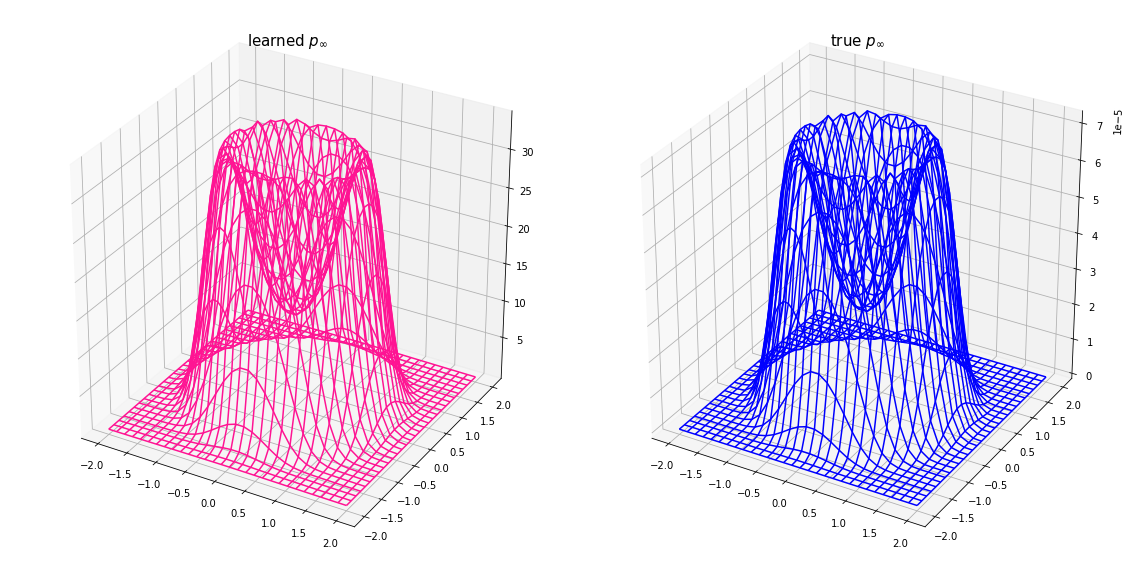

In [7]:
import matplotlib.pyplot as plt

def plot_solutions(learned, true, resolution=30, low=domain[0], high=domain[1]):
  fig = plt.figure(figsize=(16, 8))
  ax_l = fig.add_subplot(121, projection='3d')
  ax_t = fig.add_subplot(122, projection='3d')
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True).astype('float32')
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True).astype('float32')
  y = np.repeat(y, resolution, axis=0).reshape((-1, 1))
  x = np.array(list(x) * resolution).reshape((-1, 1))
  z_l = learned(x, y).numpy()
  z_t = true(x, y).numpy()
  grid = (resolution, resolution)
  x = x.reshape(grid)
  y = y.reshape(grid)
  z_l = z_l.reshape(grid)
  z_t = z_t.reshape(grid)
  ax_l.plot_wireframe(x, y, z_l, color='deeppink')
  ax_l.set_title('learned $p_\infty$', fontsize=15)
  ax_t.plot_wireframe(x, y, z_t, color='blue')
  ax_t.set_title('true $p_\infty$', fontsize=15)
  plt.tight_layout()
  plt.show()
  
def learned(x, y):
  z = tf.zeros_like(x)
  zs = [z] * (dim - 2)
  return tf.exp(solver.net(x, y, *zs))

def true(x, y):
  z = tf.zeros_like(x)
  zs = [z] * (dim - 2)
  return p_inf(x, y, *zs)

plot_solutions(learned=learned, true=true)

**Investigate the size of $θ$**

In [ ]:
solver.net.summary()